# T007 · Ligand-based screening: machine learning

Authors:

* Jan Philipp Albrecht, CADD seminar 2018, Charité/FU Berlin
* Jacob Gora, CADD seminar 2018, Charité/FU Berlin
* Talia B. Kimber, 2019-2020, [Volkamer lab](https://volkamerlab.org)
* Andrea Volkamer, 2019-2020, [Volkamer lab](https://volkamerlab.org)

__Talktorial T007__: This talktorial is part of the TeachOpenCADD pipeline described in the [first TeachOpenCADD paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x), comprising of talktorials T001-T010.

## Aim of this talktorial

Due to larger available data sources, machine learning (ML) gained momentum in drug discovery and especially in ligand-based virtual screening. In this talktorial, we learn how to use different supervised ML algorithms to predict the activity of novel compounds against our target of interest (EGFR).

### Contents in _Theory_

* Data preparation: Molecule encoding
* Machine learning (ML)
    * Supervised learning
* Model validation and evaluation
    * Validation strategy: K-fold cross-validation
    *  Performance measures

### Contents in _Practical_

* Load compound and activity data
* Data preparation
    * Data labeling
    * Molecule encoding
* Machine learning
    * Helper functions
    * Random forest classifier
    * Support vector classifier
    * Neural network classifier
    * Cross-validation

### References

* "Fingerprints in the RDKit" [slides](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf), G. Landrum, RDKit UGM 2012
* Extended-connectivity fingerprints (ECFPs): Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." [_Journal of chemical information and modeling_ 50.5 (2010): 742-754.](https://doi.org/10.1021/ci100050t)
* Machine learning (ML):
  * Random forest (RF): Breiman, L. "Random Forests". [_Machine Learning_ **45**, 5–32 (2001).](https://link.springer.com/article/10.1023%2FA%3A1010933404324)
  * Support vector machines (SVM): Cortes, C., Vapnik, V. "Support-vector networks". [_Machine Learning_ **20**, 273–297 (1995).](https://link.springer.com/article/10.1007%2FBF00994018)
  * Artificial neural networks (ANN): Van Gerven, Marcel, and Sander Bohte. "Artificial neural networks as models of neural information processing." [_Frontiers in Computational Neuroscience_ 11 (2017): 114.](https://doi.org/10.3389/fncom.2017.00114)
* Performance: 
  * Sensitivity and specificity ([Wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity))
  * ROC curve and AUC ([Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve))
* See also [github notebook by B. Merget](https://github.com/Team-SKI/Publications/tree/master/Profiling_prediction_of_kinase_inhibitors) from [*J. Med. Chem.*, 2017, 60, 474−485](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b01611) 
* Activity cutoff $pIC_{50} = 6.3$ used in this talktorial
  * Profiling Prediction of Kinase Inhibitors: Toward the Virtual Assay [<i>J. Med. Chem.</i> (2017), <b>60</b>, 474-485](https://doi.org/10.1021/acs.jmedchem.6b01611)
  * Notebook accompanying the publication mentioned before: [Notebook](https://github.com/Team-SKI/Publications/blob/master/Profiling_prediction_of_kinase_inhibitors/Build_ABL1_model.ipynb)

## Theory

To successfully apply ML, we need a large data set of molecules, a molecular encoding, a label per molecule in the data set, and a ML algorithm to train a model. Then, we can make predictions for new molecules.

![ML overview](images/ML_overview.png)

_Figure 1_: Machine learning overview: Molecular encoding, label, ML algorithm, prediction. Figure by Andrea Volkamer.

### Data preparation: Molecule encoding

For ML, molecules need to be converted into a list of features. Often molecular fingerprints are used as representation. 

The fingerprints used in this talktorial as implemented in RDKit (more info can be found in a  [presentation by G. Landrum](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)) are:

* **maccs**: 'MACCS keys are 166 bit structural key descriptors in which each bit is associated with a SMARTS pattern.' (see OpenEye's `MACCS` [docs](https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#maccs))
* **Morgan fingerprints** (and **ECFP**): 'Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling.' (see ChemAxon's `ECFP` [docs](https://docs.chemaxon.com/display/docs/Extended+Connectivity+Fingerprint+ECFP)) The original implementation of the ECFPs was done in Pipeline Pilot which is not open-source. Instead we use the implementation from RDKit which is called Morgan fingerprint. The two most important parameters of these fingerprints are the radius and fingerprint length. The first specifies the radius of circular neighborhoods considered for each atom. Here two radii are considered: 2 and 3. The length parameter specifies the length to which the bit string representation is hashed. The default length is 2048.

### Machine learning (ML)

ML can be applied for (text adapted from [scikit-learn page](http://scikit-learn.org/stable/)):

* **Classification (supervised)**: Identify which category an object belongs to (e.g. : Nearest neighbors, Naive Bayes, RF, SVM, ...)
* Regression: Prediction of a continuous-values attribute associated with an object
* Clustering (unsupervised): Automated grouping of similar objects into sets (see also **Talktorial T005**)

#### Supervised learning

A learning algorithm creates rules by finding patterns in the training data.

* **Random Forest (RF)**: Ensemble of decision trees. A single decision tree splits the features of the input vector in a way that maximizes an objective function. In the random forest algorithm, the trees that are grown are de-correlated because the choice of features for the splits are chosen randomly.
* **Support Vector Machines (SVMs)**: SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. The classifier is based on the idea of maximizing the margin as the objective function.  
* **Artificial neural networks (ANNs)**: An ANN is based on a collection of connected units or nodes called artificial neurons which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it.


![ANN_example](images/ANN_wiki.png)

_Figure 2_: Example of a neural network with one hidden layer. Figure taken from [Wikipedia](https://en.wikipedia.org/wiki/Artificial_neural_network).

### Model validation and evaluation

#### Validation strategy: K-fold cross validation

* This model validation technique splits the dataset in two groups in an iterative manner:
    * Training data set: Considered as the known dataset on which the model is trained
    * Test dataset: Unknown dataset on which the model is then tested
    * Process is repeated k-times
* The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over-fitting and to assess the generalization ability of the model.

#### Performance measures

* **Sensitivity**, also true positive rate
    * TPR = TP/(FN + TP) 
    * _Intuitively_: Out of all actual positives, how many were predicted as positive?
* **Specificity**, also true negative rate
    * TNR = TN/(FP + TN)
    * _Intuitively_: Out of all actual negatives, how many were predicted as negative?
* **Accuracy**, also the trueness
    * ACC = (TP + TN)/(TP + TN + FP + FN)
    * _Intuitively_: Proportion of correct predictions.
* **ROC-curve**, receiver operating characteristic curve
    * A graphical plot that illustrates the diagnostic ability of our classifier
    * Plots the sensitivity against the specificity
* **AUC**, the area under the ROC curve (AUC):  
    * Describes the probability that a classifier will rank a randomly chosen positive instance higher than a negative one
    * Values between 0 and 1, the higher the better

| What the model predicts  | True active  |  True inactive |
|---|---|---|
| active  |  True Positive (TP) |  False Positive (FP) |
| inactive  |  False Negative (FN) |  True Negative (TN) |

## Practical

In [43]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Load compound and activity data

Let's start by loading our data, which focuses on the Epidermal growth factor receptor (EGFR) kinase. The *csv* file from **Talktorial T002** is loaded into a dataframe with the important columns:

* CHEMBL-ID
* SMILES string of the corresponding compound
* Measured affinity: pIC50

In [3]:
# Read data from previous talktorials
chembl_df = pd.read_csv(
    HERE / "../T002_compound_adme/data/A2A_compounds_lipinski.csv",
    index_col=0,
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3545, 10)


,molecule_chembl_id,Ki,units,smiles,pKi,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL2419149,0.0042,nM,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(Br)cc1,11.376751,398.949951,5,0,5.65307,True
1,CHEMBL2419144,0.0047,nM,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(F)cc1,11.327902,339.030018,5,0,5.02967,True
2,CHEMBL1093479,0.0082,nM,S=c1sc2c(ncn3nc(-c4ccco4)nc23)n1-c1cccc(I)c1,11.086186,476.921500,8,0,4.72379,True
3,CHEMBL2419139,0.0100,nM,CCn1c(/N=C/c2ccc(Br)cc2)c(C#N)sc1=S,11.000000,350.949951,5,0,4.68377,True
4,CHEMBL1092271,0.0160,nM,C=CCn1c(=S)sc2c1ncn1nc(-c3ccco3)nc21,10.795880,315.024852,8,0,3.31599,True


In [5]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pKi"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pKi
0,CHEMBL2419149,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(Br)cc1,11.376751
1,CHEMBL2419144,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(F)cc1,11.327902
2,CHEMBL1093479,S=c1sc2c(ncn3nc(-c4ccco4)nc23)n1-c1cccc(I)c1,11.086186
3,CHEMBL2419139,CCn1c(/N=C/c2ccc(Br)cc2)c(C#N)sc1=S,11.000000
4,CHEMBL1092271,C=CCn1c(=S)sc2c1ncn1nc(-c3ccco3)nc21,10.795880


### Data preparation

#### Data labeling
We need to classify each compound as active or inactive. Therefore, we use the pIC50 value.

* pIC50 = -log10(IC50) 
* IC50 describes the amount of substance needed to inhibit, _in vitro_, a process by 50% .
* A common cut-off value to discretize pIC50 data is 6.3, which we will use for our experiment (refer to [<i>J. Med. Chem.</i> (2017), <b>60</b>, 474-485](https://doi.org/10.1021/acs.jmedchem.6b01611) and the corresponding
[notebook](https://github.com/Team-SKI/Publications/blob/master/Profiling_prediction_of_kinase_inhibitors/Build_ABL1_model.ipynb))
* Note that there are several other suggestions for an activity cut-off ranging from an pIC50 value of 5 to 7 in the literature or even to define an exclusion range when not to take data points. 

In [7]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pKi of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pKi >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 2264
Number of inactive compounds: 1281


In [8]:
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pKi,active
0,CHEMBL2419149,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(Br)cc1,11.376751,1.0
1,CHEMBL2419144,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(F)cc1,11.327902,1.0
2,CHEMBL1093479,S=c1sc2c(ncn3nc(-c4ccco4)nc23)n1-c1cccc(I)c1,11.086186,1.0
3,CHEMBL2419139,CCn1c(/N=C/c2ccc(Br)cc2)c(C#N)sc1=S,11.000000,1.0
4,CHEMBL1092271,C=CCn1c(=S)sc2c1ncn1nc(-c3ccco3)nc21,10.795880,1.0


#### Molecule encoding

Now we define a function `smiles_to_fp` to generate fingerprints from SMILES.
For now, we incorporated the choice between the following fingerprints:

* maccs
* morgan2 and morgan3

In [9]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [10]:
compound_df = chembl_df.copy()

In [11]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pKi,active,fp
0,CHEMBL2419149,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(Br)cc1,11.376751,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2419144,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(F)cc1,11.327902,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL1093479,S=c1sc2c(ncn3nc(-c4ccco4)nc23)n1-c1cccc(I)c1,11.086186,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Machine Learning (ML)

In the following, we will try several ML approaches to classify our molecules. We will use:

* Random Forest (RF)
* Support Vector Machine (SVM) 
* Artificial Neural Network (ANN) 

Additionally, we will comment on the results.

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function `model_training_and_validation` which fits a model on a random train-test split of the data and returns measures such as accuracy, sensitivity, specificity and AUC evaluated on the test set. We also plot the ROC curves using `plot_roc_curves_for_models`.

We then define a function named `crossvalidation` which executes a cross validation procedure and prints the statistics of the results over the folds.

#### Helper functions
Helper function to plot customized ROC curves. Code inspired by [stackoverflow](https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python).

In [12]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

Helper function to calculate model performance.

In [13]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

 Helper function to fit a machine learning model on a random train-test split of the data and return the performance measures.

In [14]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

**Preprocessing**: Split the data (will be reused for the other models)

In [15]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2836
Test data size: 709


#### Random forest classifier

We start with a random forest classifier, where we first set the parameters.

We train the model on a random train-test split and plot the results.

In [16]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [17]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.91
Specificity: 0.68
AUC: 0.90


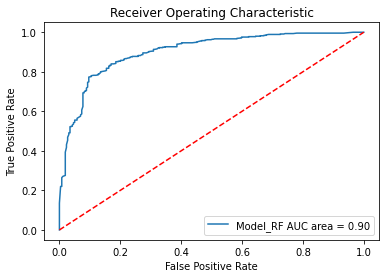

In [18]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

#### Support vector classifier
Here we train a SVM with a radial-basis function kernel (also: squared-exponential kernel). 
For more information, see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [19]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.92
Specificity: 0.68
AUC: 0.90


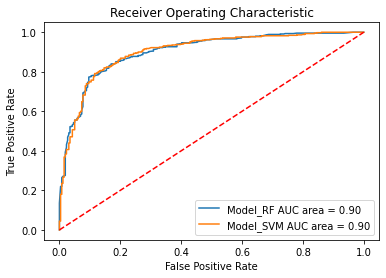

In [20]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

#### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons. As before, we do the crossvalidation procedure and plot the results. For more information on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [21]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.90
Specificity: 0.66
AUC: 0.87


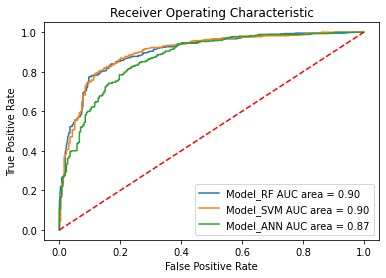

In [22]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

Our models show very good values for all measured values (see AUCs) and thus seem to be predictive.

#### Cross-validation

Next, we will perform cross-validation experiments with the three different models.
Therefore, we define a helper function for machine learning model training and validation in a cross-validation loop.

In [23]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

**Cross-validation**

We now apply cross-validation and show the statistics for all three ML models. In real world conditions, cross-validation usually applies 5 or more folds, but for the sake of performance we will reduce it to 3. You can change the value of `N_FOLDS` in this cell below.

In [24]:
N_FOLDS = 3

_Note_: Next cell takes long to execute

In [25]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.82 	and std : 0.00 
Mean sensitivity: 0.89 	and std : 0.01 
Mean specificity: 0.70 	and std : 0.01 
Mean AUC: 0.88 	and std : 0.01 
Time taken : 0.70s


Model_SVM
Mean accuracy: 0.82 	and std : 0.00 
Mean sensitivity: 0.90 	and std : 0.00 
Mean specificity: 0.69 	and std : 0.02 
Mean AUC: 0.89 	and std : 0.01 
Time taken : 5.16s


Model_ANN
Mean accuracy: 0.79 	and std : 0.01 
Mean sensitivity: 0.88 	and std : 0.00 
Mean specificity: 0.65 	and std : 0.02 
Mean AUC: 0.85 	and std : 0.01 
Time taken : 2.15s



We look at the cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [26]:
# Reset data frame
compound_df = chembl_df.copy()

In [27]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pKi,active,fp
0,CHEMBL2419149,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(Br)cc1,11.376751,1.0,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL2419144,N#Cc1sc(=S)n(-c2ccccc2)c1/N=C/c1ccc(F)cc1,11.327902,1.0,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL1093479,S=c1sc2c(ncn3nc(-c4ccco4)nc23)n1-c1cccc(I)c1,11.086186,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


_Note_: Next cell takes long to execute

In [34]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.83 	and std : 0.00 
Mean sensitivity: 0.91 	and std : 0.01 
Mean specificity: 0.71 	and std : 0.02 
Mean AUC: 0.90 	and std : 0.01 
Time taken : 2.29s


Model_ANN
Mean accuracy: 0.81 	and std : 0.01 
Mean sensitivity: 0.87 	and std : 0.01 
Mean specificity: 0.70 	and std : 0.01 
Mean AUC: 0.87 	and std : 0.01 
Time taken : 11.42s



## Regresion models

So far, we have been running classification models (is the compound going to be active or not, indicated by the active column we added in the dataframe). The next step is to see if we can also train a regression model, which can be particularly interesting if we want to design our own ligands (e.g. do we predict the compound to actually bind better). We will remove the censored data (the ones with no pChEMBL value), and train another model. 

Make a new function that works with regression:

In [50]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pKi.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pKi.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

Next, create a new dataset (without censored data) and run.

In [51]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pKi.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2836
Test data size: 709


In [52]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"Mean Absolute Error (MAE): {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"Root Mean Square Error (RMSE): {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

Mean Absolute Error (MAE): 0.51 	and std : 0.02 
Root Mean Square Error (RMSE): 0.69 	and std : 0.03 



## Discussion

* Which model performed best on our data set and why?
* Was MACCS the right choice?
    
### Where can we go from here?

* We successfully trained several models. 
* The next step could be to use these models to do a classification with an unknown screening dataset to predict novel potential EGFR inhibitors.
* An example for a large screening data set is e.g. [MolPort](https://www.molport.com/shop/database-download) with over 7 million compounds.
* Our models could be used to rank the MolPort compounds and then further study those with the highest predicted probability of being active.
* For such an application, see also the [TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014) developed by S. Riniker and G. Landrum, where they trained a fusion model to screen [eMolecules](https://www.emolecules.com/) for new anti-malaria drugs.

## Quiz

* How can you apply ML for virtual screening?
* Which machine learning algorithms do you know?
* What are necessary prerequisites to successfully apply ML?